# Imports

In [ ]:
!pip install tensorflow_hub
!pip install keras tf-models-official pydot graphviz
!pip install -q tflite-model-maker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 34.4 MB/s 
     |████████████████████████████████| 1.3 MB 53.7 MB/s 
     |████████████████████████████████| 99 kB 2.4 MB/s 
     |████████████████████████████████| 4.6 MB 43.3 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 238 kB 67.5 MB/s 
     |████████████████████████████████| 352 kB 69.1 MB/s 
     |████████████████████████████████| 1.1 MB 63.4 MB/s 
     |████████████████████████████████| 636 kB 42.6 MB/s 
     |████████████████████████████████| 116 kB 75.3 MB/s 
     |████████████████████████████████| 511.7 MB 6.4 kB/s 
     |████████████████████████████████| 1.6 MB 65.7 MB/s 
     |████████████████████████████████| 5.8 MB 57.6 MB/s 
     |████████████████████████████████| 438 kB 18.7

In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 33.3 MB/s 


In [ ]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from keras.utils import np_utils

In [ ]:
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.8.2
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/
Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/pengujian/real_dataset.csv',
                 encoding='ISO-8859-1', 
                 names=[
                        'target',
                        'text'
                        ])

In [ ]:
sample_size = int(len(df)*1)
sampleDf = df.sample(sample_size, random_state=23)
x = sampleDf.text.values
y = sampleDf.target.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=32, stratify=y)


# y_test=y_test.reshape((1037,1))
# x_test=x_test.reshape((1037,1))
# x_train=x_train.reshape((4147,1))
# y_train=y_train.reshape((4147,1))
# y=y.reshape((5184,1))
# x=x.reshape((5184,1))


print(y.shape)
print(x.shape)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(32560,)
(32560,)
(26048,)
(26048,)
(6512,)
(6512,)


In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

In [ ]:
print(dummy_y_train.shape)
print(dummy_y_test.shape)

(26048, 2)
(6512, 2)


In [ ]:
encoder_fname = 'twitter_classes.npy'
my_wd = '/content/gdrive/MyDrive/pengujian/best'
np.save(os.path.join(my_wd, encoder_fname) , encoder.classes_)

In [ ]:
bert_layer = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
    # "https://tfhub.dev/jeongukjae/distilbert_multi_cased_L-6_H-768_A-12/1",
                            trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
do_lower_case

False

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [ ]:
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')  # seperation token. Would bemuch more useful if you had a multiple text input.
   return tokenizer.convert_tokens_to_ids(tokens)

tweets = tf.ragged.constant([
    encode_names(n) for n in x_train])

In [ ]:
print('Tokenized Tweets shape', tweets.shape.as_list())

Tokenized Tweets shape [26048, None]


In [ ]:
tweets[0]

<tf.Tensor: shape=(12,), dtype=int32, numpy=
array([48792, 59411, 26709, 10215, 78978, 10230, 24604, 12718, 12443,
       37997, 10237,   102], dtype=int32)>

In [ ]:
x_train[0]

'sesuai pesanan dan packing baik terimakasih'

In [ ]:
tokenizedTweet = tokenizer.tokenize(x_train[0])
for i in tokenizedTweet:
  print(i, tokenizer.convert_tokens_to_ids([i]))

sesuai [48792]
pes [59411]
##anan [26709]
dan [10215]
pack [78978]
##ing [10230]
baik [24604]
ter [12718]
##ima [12443]
##kasi [37997]
##h [10237]


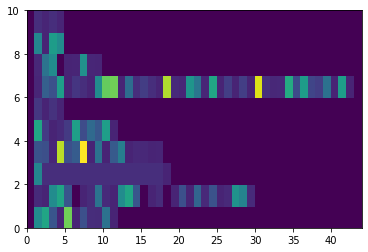

In [ ]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*tweets.shape[0]
input_word_ids = tf.concat([cls, tweets], axis=-1)
_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())

In [ ]:
input_word_ids

<tf.RaggedTensor [[101, 48792, 59411, 26709, 10215, 78978, 10230, 24604, 12718, 12443, 37997,
  10237, 102]                                                               ,
 [101, 11887, 10174, 48792, 59411, 26709, 193, 10240, 12591, 38297, 11887,
  10174, 48792, 59411, 26709, 193, 10240, 12591, 180, 10240, 24552, 10219,
  32444, 11531, 25257, 10120, 11551, 51935, 45155, 11972, 102]            ,
 [101, 46267, 13321, 13321, 13321, 13321, 13321, 13321, 13321, 13321, 13321,
  13321, 13321, 13321, 13321, 13321, 13321, 13321, 10112, 102]              ,
 ..., [101, 24552, 10219, 10144, 15008, 99646, 102],
 [101, 188, 11703, 77951, 10240, 48792, 59411, 26709, 102],
 [101, 55248, 56332, 66148, 15694, 13133, 11390, 10671, 11390, 77120, 10676,
  68297, 10801, 48792, 59411, 26709, 102]                                   ]>

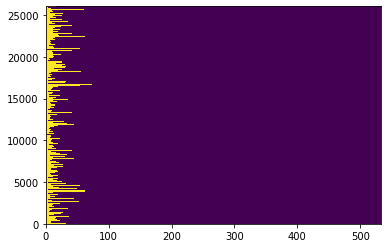

In [ ]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

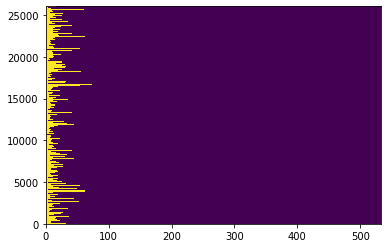

In [ ]:
type_cls = tf.zeros_like(cls)
type_tweet = tf.ones_like(tweets)
input_type_ids = tf.concat([type_cls, type_tweet], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

In [ ]:
input_type_ids

<tf.Tensor: shape=(26048, 532), dtype=int32, numpy=
array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]], dtype=int32)>

In [ ]:
# max_seq_length = int(0.5*max_seq_length)
max_seq_length = int(128)
print('Max length is:', max_seq_length)

Max length is: 128


In [ ]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
X_train = bert_encode(x_train, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

In [ ]:
num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

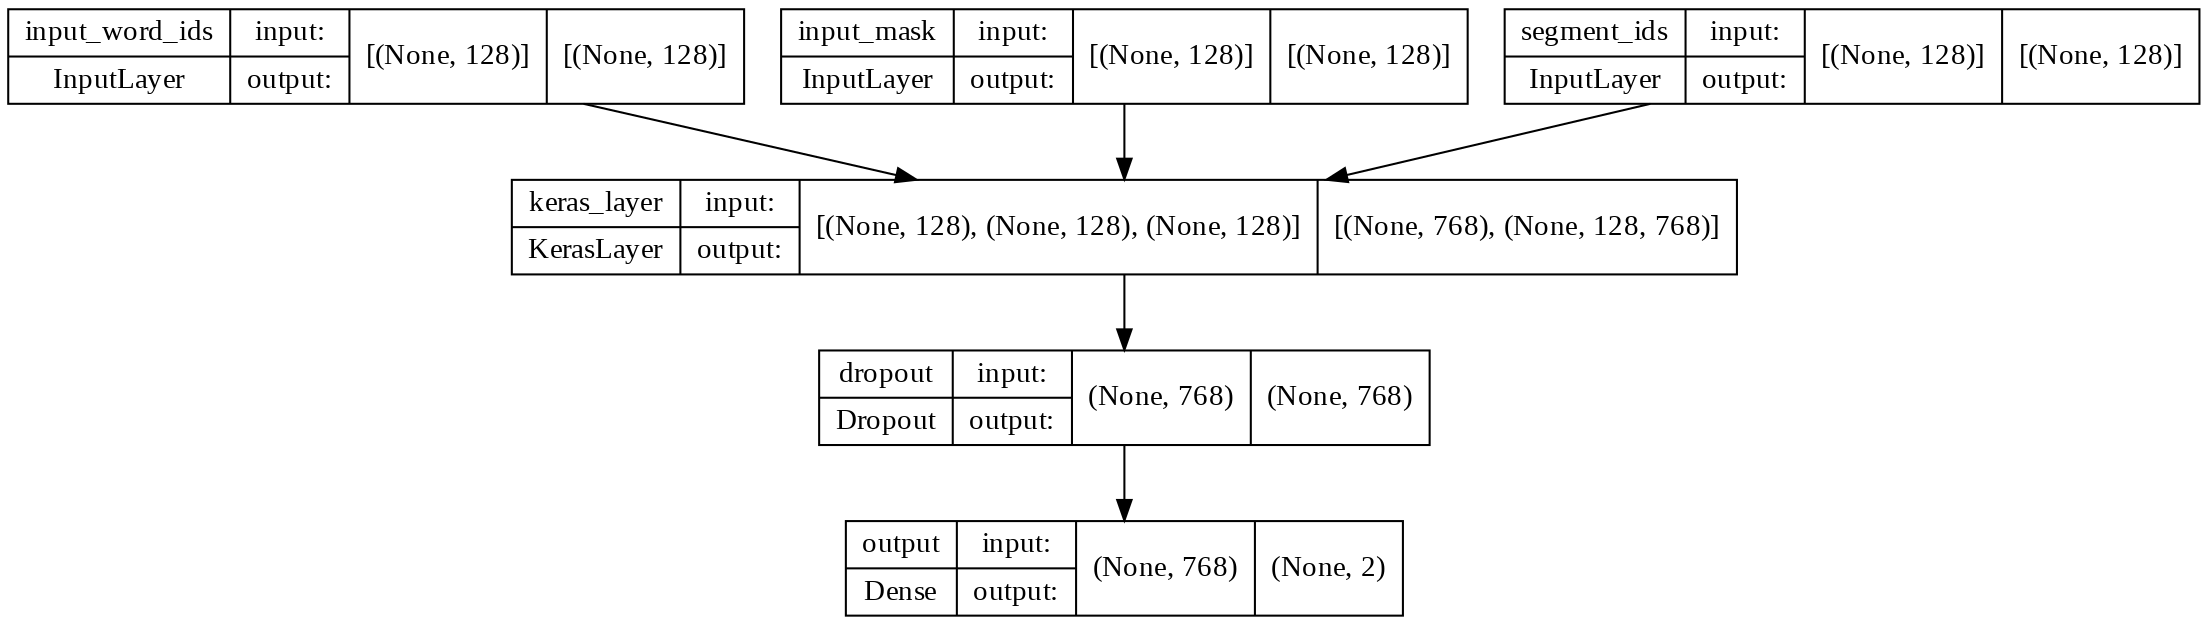

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=148)

In [ ]:
epochs = 4
batch_size = 16  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    3e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

# optimizer = adam

In [ ]:
model.compile(
              # optimizer='adam',
              optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy']
              )

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        177853441   ['input_word_ids[0][0]',         
                                 (None, 128, 768)]                'input_mask[0][0]',         

In [ ]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1
                    )

Epoch 1/4
1628/1628 [==============================] - 915s 551ms/step - loss: 0.4757 - accuracy: 0.7813 - val_loss: 0.3842 - val_accuracy: 0.8481
Epoch 2/4
1628/1628 [==============================] - 900s 553ms/step - loss: 0.3478 - accuracy: 0.8609 - val_loss: 0.3526 - val_accuracy: 0.8547
Epoch 3/4
1628/1628 [==============================] - 900s 553ms/step - loss: 0.2805 - accuracy: 0.8970 - val_loss: 0.3871 - val_accuracy: 0.8535
Epoch 4/4
1628/1628 [==============================] - 880s 541ms/step - loss: 0.2230 - accuracy: 0.9235 - val_loss: 0.4587 - val_accuracy: 0.8524


In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

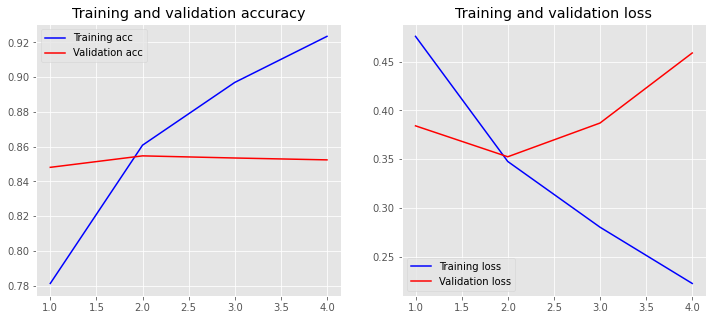

In [ ]:
plot_history(history)

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_fname = 'twitter_BERT'
my_wd = '/content/gdrive/MyDrive/pengujian/best'

model.save(os.path.join(my_wd, model_fname))

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/pengujian/best/twitter_BERT/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/pengujian/best/twitter_BERT/assets


In [ ]:
model_fname = 'twitter_BERT'
my_wd = '/content/gdrive/MyDrive/pengujian/best'

new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))

In [ ]:
loss, accuracy = new_model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.8524


In [ ]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        177853441   ['input_word_ids[0][0]',         
                                 (None, 128, 768)]                'input_mask[0][0]',         

In [ ]:
tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

In [ ]:
tokenizedTweet = tokenizerSaved.tokenize(x_train[0])
for i in tokenizedTweet:
  print(i, tokenizerSaved.convert_tokens_to_ids([i]))

sesuai [48792]
pes [59411]
##anan [26709]
dan [10215]
pack [78978]
##ing [10230]
baik [24604]
ter [12718]
##ima [12443]
##kasi [37997]
##h [10237]


In [ ]:
sample_size = int(len(df)*1)
sampleDf = df.sample(sample_size, random_state=42)  # notice the random state changes
x = sampleDf.text.values
y = sampleDf.target.values
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y, test_size=0.20, random_state=42, stratify=y)  # notice the random state changes

In [ ]:
encoder_fname = 'twitter_classes.npy'
my_wd = '/content/gdrive/MyDrive/pengujian/best'

encoder = LabelEncoder()
encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

encoded_Y_test2 = encoder.transform(y_test2)
encoded_Y_train2 = encoder.transform(y_train2)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test2 = np_utils.to_categorical(encoded_Y_test2)
dummy_y_train2 = np_utils.to_categorical(encoded_Y_train2)

In [ ]:
model_fname = 'twitter_BERT'
my_wd = '/content/gdrive/MyDrive/pengujian/best'

tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

In [ ]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
print('Max sequence length is:', max_seq_length)

Max sequence length is: 128


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        177853441   ['input_word_ids[0][0]',         
                                 (None, 128, 768)]                'input_mask[0][0]',         

In [ ]:
X_train2 = bert_encode(x_train2, tokenizerSaved, max_seq_length)
X_test2 = bert_encode(x_test2, tokenizerSaved, max_seq_length)

In [ ]:
x_train2[0]

'vgghvbnkjhgfvvbnnjhhhbbbnkkkkkkkkkk'

In [ ]:
model_fname = 'twitter_BERT'
my_wd = '/content/gdrive/MyDrive/pengujian/best'

new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        177853441   ['input_word_ids[0][0]',         
                                 (None, 128, 768)]                'input_mask[0][0]',         

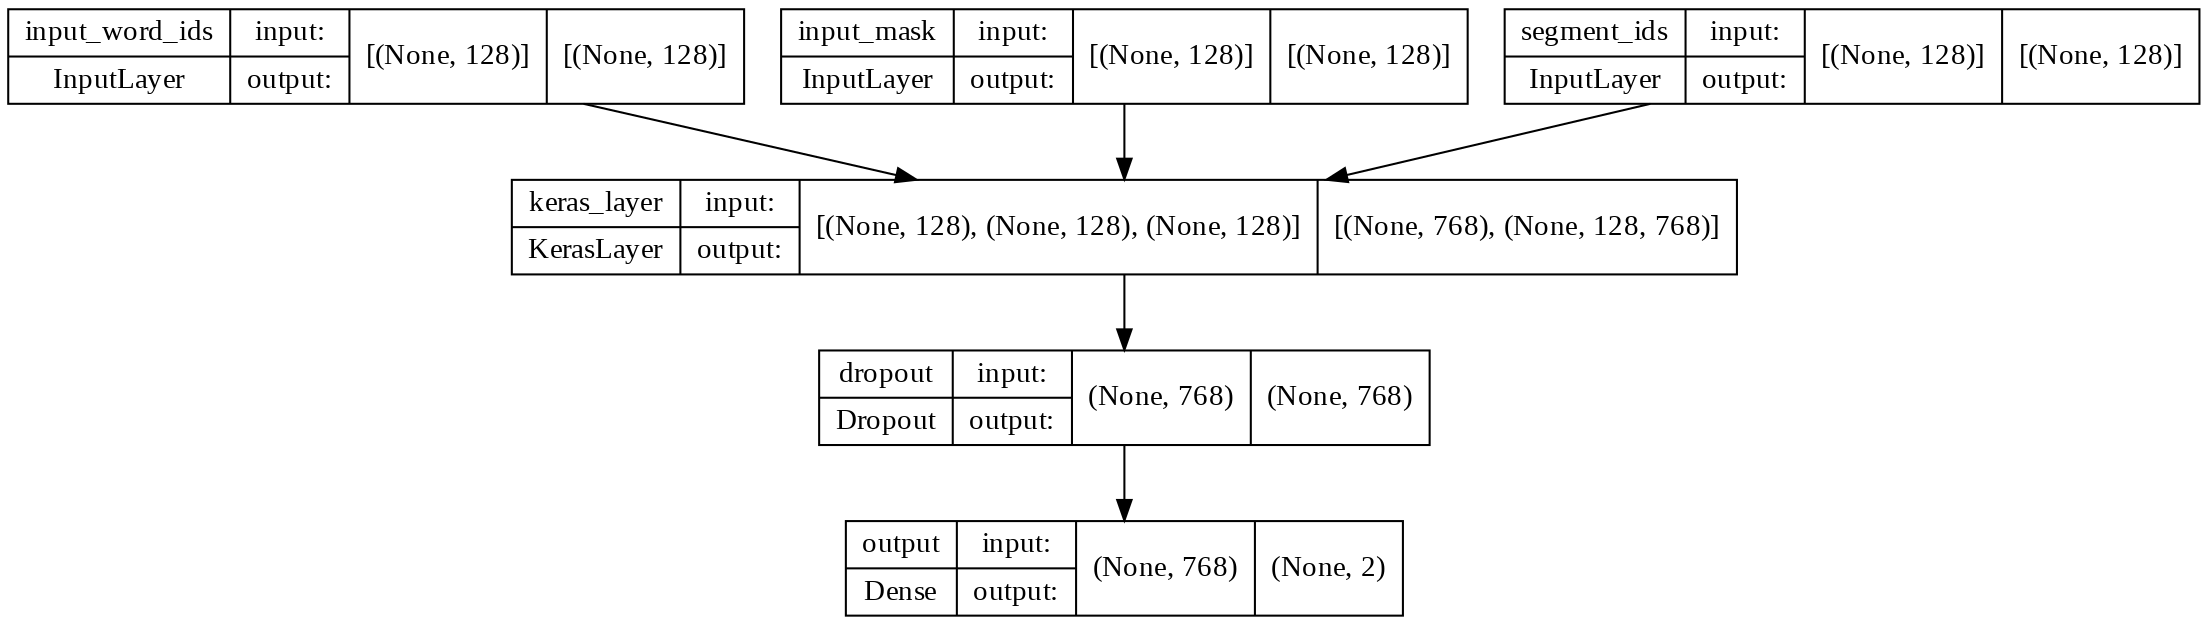

In [ ]:
tf.keras.utils.plot_model(new_model, show_shapes=True, dpi=148)

In [ ]:
epochs = 4
batch_size = 16  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train2)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

In [ ]:
optimizer = nlp.optimization.create_optimizer(
    3e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
new_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history2 = new_model.fit(X_train2,  # using new training set
                         dummy_y_train2,  # using new training set
                         epochs=epochs,
                         batch_size=batch_size,
                         validation_data=(X_test, dummy_y_test),  # using old test dataset
                         verbose=1)

Epoch 1/4
1628/1628 [==============================] - 921s 556ms/step - loss: 0.2842 - accuracy: 0.8981 - val_loss: 0.2937 - val_accuracy: 0.8850
Epoch 2/4
1628/1628 [==============================] - 905s 556ms/step - loss: 0.2500 - accuracy: 0.9132 - val_loss: 0.2344 - val_accuracy: 0.9206
Epoch 3/4
1628/1628 [==============================] - 904s 555ms/step - loss: 0.1969 - accuracy: 0.9390 - val_loss: 0.2115 - val_accuracy: 0.9372
Epoch 4/4
1628/1628 [==============================] - 884s 543ms/step - loss: 0.1438 - accuracy: 0.9587 - val_loss: 0.2112 - val_accuracy: 0.9449


In [ ]:
for i in history2.history:
  for ele in history2.history[i]:
    history.history[i].append(ele)

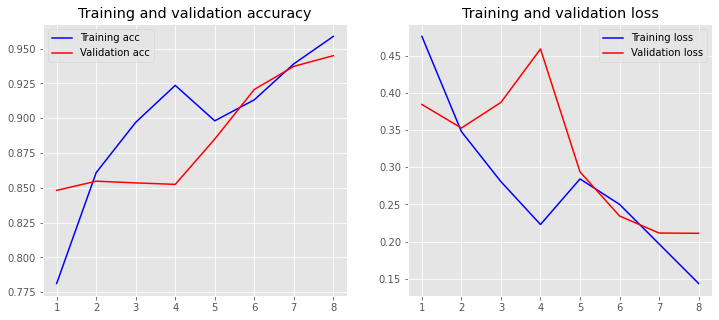

In [ ]:
plot_history(history)

In [ ]:
new_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_fname = 'twitter_BERT'
my_wd = '/content/gdrive/MyDrive/pengujian/best'

new_model.save(os.path.join(my_wd, model_fname))

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/pengujian/best/twitter_BERT/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/pengujian/best/twitter_BERT/assets


In [ ]:
model_fname = 'twitter_BERT'
my_wd = '/content/gdrive/MyDrive/pengujian/best'

new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))

In [ ]:
# new_model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

In [ ]:
loss, accuracy = new_model.evaluate(X_test, dummy_y_test, verbose=False)
print("Accuracy:  {:.4f}".format(accuracy))

Accuracy:  0.9449
